In [342]:
import numpy as np
from scipy.stats import norm, bernoulli
import matplotlib.pyplot as plt
import seaborn as sns

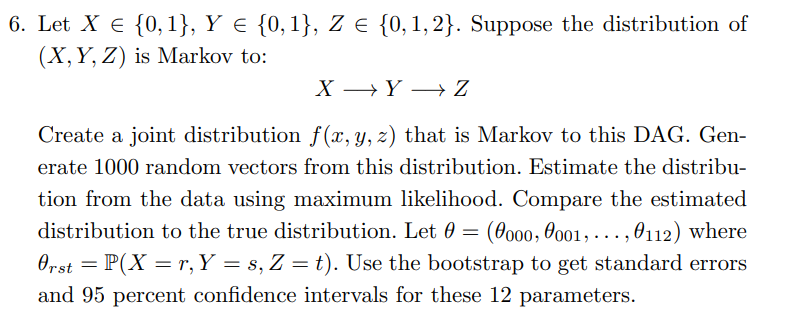

This game consists of two rounds. In round 1 you flip three coins in sequence. Let X=1 if the first flip is heads, otherwise X=0. Let Y = 1 if there are at least two heads in total, otherwise Y = 0.

In round 2, you roll a dice. If Y=1, Z=0 if the roll is {1, 2}, Z=1 if the roll is {3, 4} and Z=2 if the roll is {5, 6}. Otherwise Z=1 if the roll is a six and Z=0 otherwise.

These are the expected distributions:

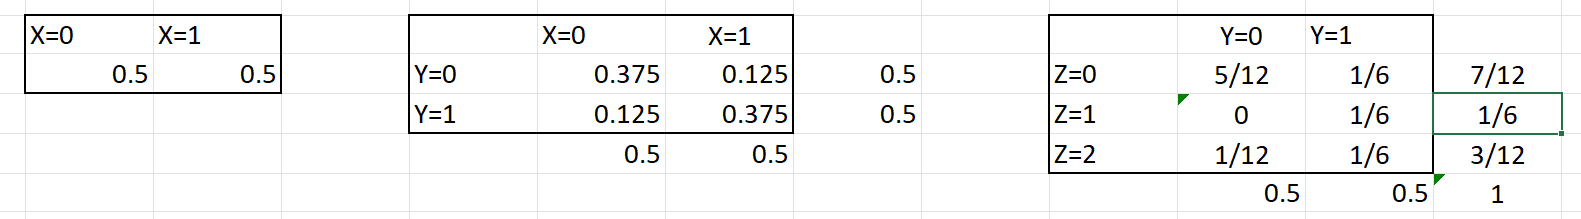

The joint probability distribution of all three is

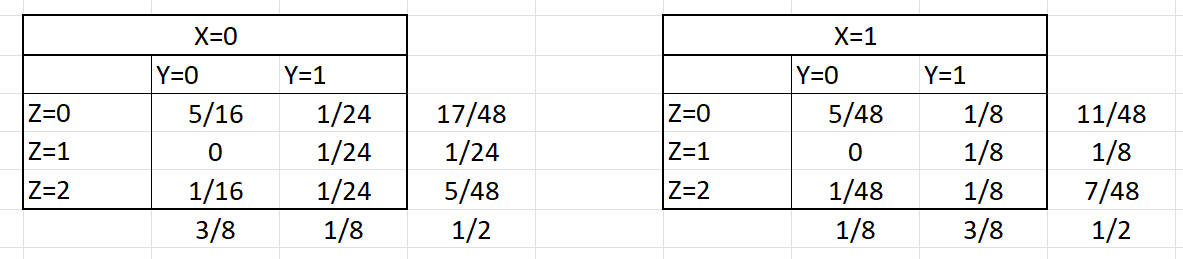

In [152]:
N=1000

X = np.random.choice([0, 1], p=[0.5, 0.5], size=N)
Y = X *np.random.choice([0, 1], p=[0.25, 0.75], size=N) + (1 - X) * np.random.choice([0, 1], p=[0.75, 0.25], size=N)

Z = Y * np.random.choice([0, 1, 2], p=[1/3, 1/3, 1/3], size=N) + (1 - Y) * np.random.choice([0, 1, 2], p=[5/6, 0, 1/6], size=N)

results = np.concatenate([X, Y, Z]).reshape(N, 3)

In [153]:
print(np.sum(np.logical_and(Y == 1, Z==2))/N)
print(np.sum(np.logical_and(Y==0, Z==2))/N)

0.168
0.092


In [154]:
pxhat = np.array([np.sum(1 - X), np.sum(X)])/N
print(pxhat)



[0.494 0.506]


In [155]:
pygivenX = np.array([[np.sum((1-X)*(1-Y)), np.sum(X*(1-Y))], [np.sum(Y*(1-X)), np.sum(X*Y)]])/N

print(pygivenX)

[[0.378 0.115]
 [0.116 0.391]]


In [156]:
pyhat = np.sum(pygivenX, axis=1)
print(pyhat, "\n")

pzgiveny = np.array([[np.sum((Z==0) * (Y==0)), np.sum((Z==0) * (Y==1))], [np.sum((Z==1) * (Y==0)), np.sum((Z==1) * (Y==1))], [np.sum((Z==2) * (Y==0)), np.sum((Z==2) * (Y==1))]])/N
print(pzgiveny)

print(pzgiveny/pyhat)

[0.493 0.507] 

[[0.401 0.16 ]
 [0.    0.179]
 [0.092 0.168]]
[[0.81338742 0.31558185]
 [0.         0.3530572 ]
 [0.18661258 0.33136095]]


In [172]:
B=2500

XBoot = np.random.choice([0, 1], p=pxhat, size=(N,B))

YBoot = XBoot * np.random.choice([0, 1], p=(pygivenX/pxhat)[:,1], size=(N, B)) + (1 - XBoot) * np.random.choice([0, 1], p=(pygivenX/pxhat)[:,0], size=(N,B))

ZBoot = YBoot * np.random.choice([0, 1, 2], p=(pzgiveny/pyhat)[:,1], size=(N, B)) + (1 - YBoot) * np.random.choice([0, 1, 2], p=(pzgiveny/pyhat)[:,0], size=(N,B))


In [171]:
print(pxhat)
print((pygivenX/pxhat)[:,0])
print((pygivenX/pxhat)[:,1])
print((pzgiveny/pyhat)[:,1])
print((pzgiveny/pyhat)[:,0])


[0.494 0.506]
[0.76518219 0.23481781]
[0.22727273 0.77272727]
[0.31558185 0.3530572  0.33136095]
[0.81338742 0.         0.18661258]


In [161]:
def theta(X, Y, Z, x, y, z):
    return np.sum(np.logical_and(np.logical_and((X==x), (Y==y)), (Z==z)), axis=0)/len(X)

In [184]:
thetas = np.array([theta(X, Y, Z, x, y, z) for x in range(2) for y in range(2) for z in range(3)])
print(thetas)

[0.311 0.    0.067 0.045 0.036 0.035 0.09  0.    0.025 0.115 0.143 0.133]


In [176]:
thetaBoots = np.array([theta(XBoot, YBoot, ZBoot, x, y, z) for x in range(2) for y in range(2) for z in range(3)])

In [185]:
print(thetaBoots.shape)
print(thetaBoots[:,0])

(12, 2500)
[0.313 0.    0.06  0.032 0.031 0.037 0.095 0.    0.011 0.127 0.147 0.147]


In [195]:
ses = thetaBoots.std(axis=1)
print(ses)

[0.0146559  0.         0.0080868  0.00601554 0.00610635 0.00593469
 0.00923315 0.         0.00454014 0.01036866 0.01090215 0.01017015]


Calculating the quantile confidence interval

In [190]:
alpha = 0.05
Cs = np.array([np.quantile(thetaBoots, alpha/2, axis=1), np.quantile(thetaBoots, 1-alpha/2, axis=1)])

In [193]:
print(Cs.T)

[[0.279 0.337]
 [0.    0.   ]
 [0.056 0.087]
 [0.026 0.049]
 [0.029 0.053]
 [0.027 0.05 ]
 [0.076 0.112]
 [0.    0.   ]
 [0.013 0.031]
 [0.103 0.143]
 [0.117 0.159]
 [0.11  0.15 ]]


We know that these are proportions, so we can use the fact that proportions can be approximated well with a normal distribution and that the standard error is $se^2 = \frac{\hat{p}(1-\hat{p})}{n}$

In [208]:
se_normal = np.sqrt(thetas*(1-thetas)/N)
print(se_normal)

[0.01463827 0.         0.00790639 0.00655553 0.00589101 0.00581163
 0.00904986 0.         0.0049371  0.01008836 0.01107028 0.0107383 ]


In [209]:
alpha = 0.05

C_normal = np.array([thetas + se_normal * norm.ppf(alpha / 2), thetas + se_normal * norm.ppf(1 - alpha / 2)])
print(C_normal.T)

[[0.28230951 0.33969049]
 [0.         0.        ]
 [0.05150376 0.08249624]
 [0.03215139 0.05784861]
 [0.02445383 0.04754617]
 [0.02360942 0.04639058]
 [0.0722626  0.1077374 ]
 [0.         0.        ]
 [0.01532345 0.03467655]
 [0.09522718 0.13477282]
 [0.12130266 0.16469734]
 [0.11195333 0.15404667]]


This method is not much different to the Bootstrap values

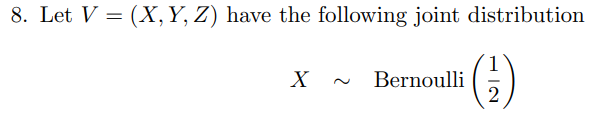

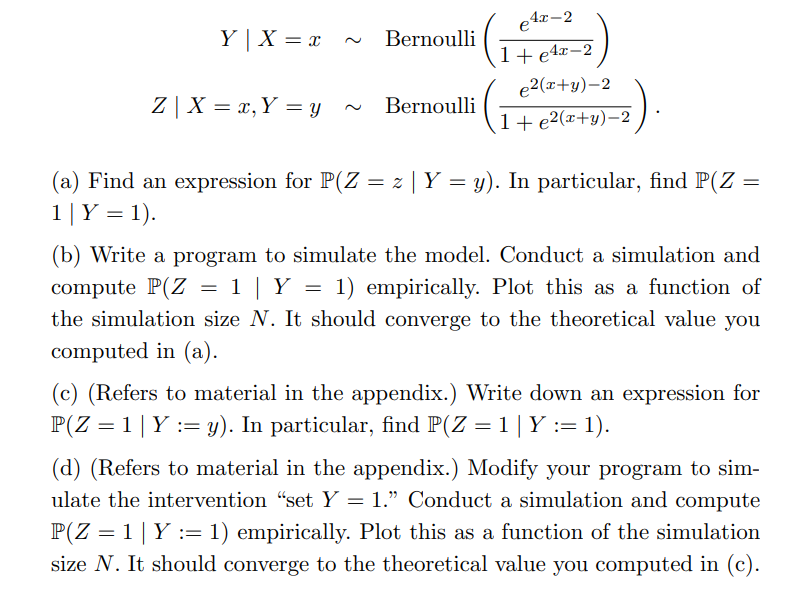

In [325]:
highp = np.e ** 2 / (1 + np.e ** 2)
lowp = 1 / (1 + np.e ** 2)



XgivenY = np.array([[highp, lowp], [lowp, highp]])
print(XgivenY, "\n\n")

ZgivenXY = np.array([[[highp, lowp], [0.5, 0.5]], [[0.5, 0.5], [lowp, highp]]])
print(ZgivenXY)

def ZgivenY(y, z):
    return np.sum(np.array([[[highp, lowp], [0.5, 0.5]], [[0.5, 0.5], [lowp, highp]]]) * np.array([[highp, lowp], [lowp, highp]]).reshape((2, 2, 1)), axis=0)[y, z]


[[0.88079708 0.11920292]
 [0.11920292 0.88079708]] 


[[[0.88079708 0.11920292]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.11920292 0.88079708]]]


In [357]:
ZgivenY(y=1, z=1)

0.16459504641456535

In [328]:
N=1000000

X = bernoulli.rvs(0.5, size = N)
yps = np.exp(4 * X - 2) / (1 + np.exp(4 * X - 2))
Y = bernoulli.rvs(yps)
zps = np.exp(2 * (X + Y) - 2) / (1 + np.exp(2 * (X + Y) - 2))
Z = bernoulli.rvs(zps)

In [333]:
np.mean(np.logical_and(Z==1, Y==1))/np.mean(Y)


0.8353116468835311

Now onto the intervention of Y:=1

In [345]:
ptheory = 1/2 * (1/2 + np.e**2 / (1 + np.e ** 2))
print(ptheory)

0.6903985389889413


In [354]:
N=10000000

X = bernoulli.rvs(0.5, size = N)
yps = np.exp(4 * X - 2) / (1 + np.exp(4 * X - 2))
#Y = bernoulli.rvs(yps)
Y = np.ones(N)
zps = np.exp(2 * (X + Y) - 2) / (1 + np.exp(2 * (X + Y) - 2))
Z = bernoulli.rvs(zps)

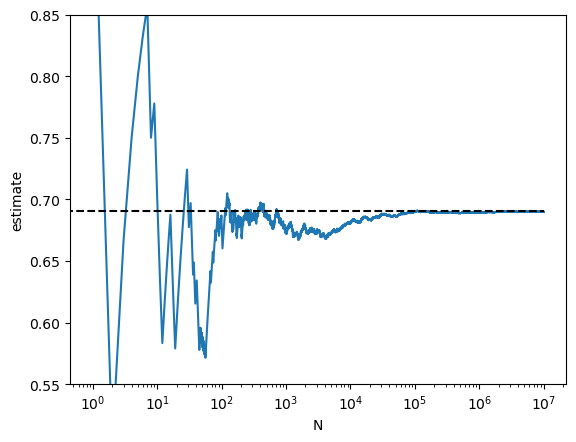

In [356]:
cummean = np.cumsum(Z)/np.arange(1, len(Z) + 1)

plt.plot(np.arange(1, N+1), cummean)
plt.hlines(ptheory, xmin=0, xmax = N, linestyles='--', color='k')
plt.xscale('log')
plt.ylim([0.55, 0.85])
#plt.yscale('log')
plt.xlabel('N')
plt.ylabel('estimate')
plt.show()

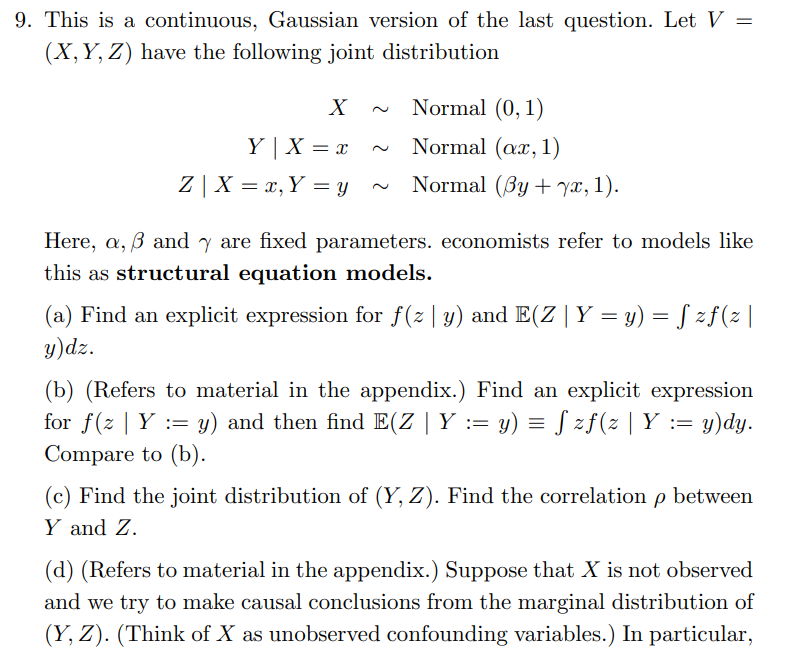

In [468]:
def zgiveny(z, y, alpha=1, beta=1, gamma=1):
    return norm.pdf(z, loc=(gamma+beta*alpha/(1+alpha**2))*y, scale=np.sqrt(1+beta**2/(1+alpha**2)))

def fy(y, alpha):
    return norm.pdf(y, loc=0, scale=np.sqrt(1+alpha**2))

In [469]:
alpha = 0.5
beta = 1
gamma = 2
s1 = np.sqrt(1 + alpha ** 2)
s2 = np.sqrt(1 + beta ** 2 + gamma ** 2 * s1 ** 2)

N=10000000
X = norm.rvs(size=N)
Y = norm.rvs(size=N) +  X * alpha
Z = norm.rvs(size=N) + X * beta + Y * gamma

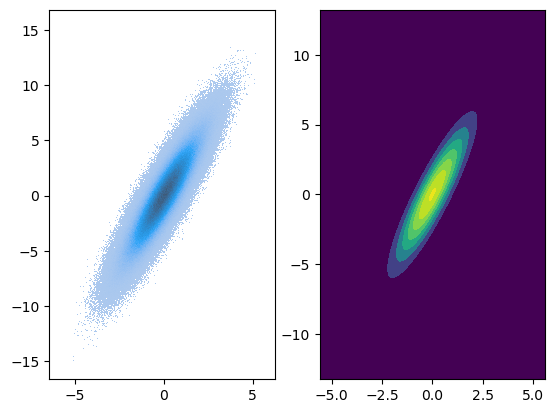

In [470]:
plt.subplot(1, 2, 1)
sns.histplot(x=Y, y=Z)
ys = np.linspace(-5 * s1, 5 * s1, 1000)
zs = np.linspace(-5 * s2, 5 * s2, 1000)
Ymesh, Zmesh = np.meshgrid(ys, zs)
f = zgiveny(Zmesh, Ymesh, alpha=alpha, beta=beta, gamma=gamma) * fy(Ymesh, alpha=alpha)
plt.subplot(1, 2, 2)
plt.contourf(ys, zs, f, levels=8, norm='log')
plt.show()

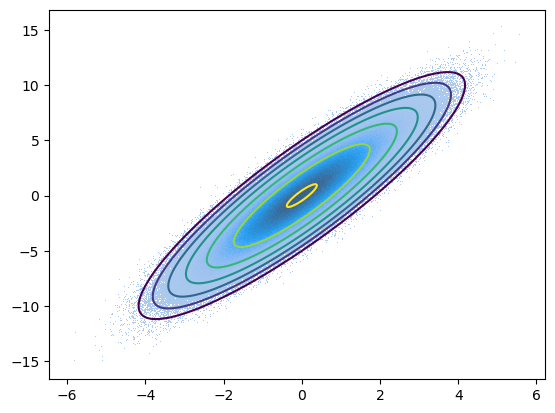

In [471]:
sns.histplot(x=Y, y=Z, alpha=1)
levels = np.logspace(-4, -1, 7)
plt.contour(ys, zs, f, levels=levels, norm='log', alpha=1)
plt.show()

In [472]:
def theoryexpected(y):
    return  (beta * alpha / (1 + alpha ** 2) + gamma) * y

In [ ]:
def zgivenyint(z, y, alpha=alpha, beta=beta, gamma=gamma):
    return norm.pdf(z, loc=gamma*y, scale=np.sqrt(1+beta**2))

def Ezgivenyint(y, alpha=alpha, beta=beta, gamma=gamma):
    return gamma * y

In [487]:
rhotheory = (gamma * (1+alpha**2) + beta * alpha)/np.sqrt((1+alpha**2)*(1+beta**2 + gamma**2 * (1+alpha**2) + 2 * beta * gamma * alpha))
print(rhotheory)

0.8944271909999159


In [488]:
print(np.corrcoef(Y, Z))

[[1.         0.89433932]
 [0.89433932 1.        ]]


In [493]:
sigmatheory = np.array([[1+alpha**2, beta*(alpha+gamma*(1+alpha**2))],[beta*(alpha+gamma*(1+alpha**2)), 1+beta**2+gamma**2*(1+alpha**2)+2*alpha*beta*gamma]])
print(sigmatheory)

[[1.25 3.  ]
 [3.   9.  ]]


In [486]:
np.cov(Y,Z)

array([[1.25031544, 3.00035822],
       [3.00035822, 9.00164687]])

In the following, Y causes Z, but the correlation coefficient is zero

In [502]:
alpha = 1
beta = (1 + alpha ** 2) / alpha
gamma = -1

N=10000000
X = norm.rvs(size=N)
Y = norm.rvs(size=N) +  X * alpha
Z = norm.rvs(size=N) + X * beta + Y * gamma

In [503]:
print(np.corrcoef(Y,Z))

[[ 1.0000000e+00 -9.0755697e-06]
 [-9.0755697e-06  1.0000000e+00]]


In the following, Y does not cause Z, but the correlation coefficient is not zero

In [504]:
alpha = 1
beta = 1
gamma = 0

N=10000000
X = norm.rvs(size=N)
Y = norm.rvs(size=N) +  X * alpha
Z = norm.rvs(size=N) + X * beta + Y * gamma

In [505]:
print(np.corrcoef(Y,Z))

[[1.         0.50015558]
 [0.50015558 1.        ]]


In [506]:
alpha = 0.5
beta = 1
gamma = 0

N=10000000
X = norm.rvs(size=N)
Y = norm.rvs(size=N, loc=alpha)
Z = norm.rvs(size=N) + X * beta + Y * gamma

In [507]:
np.corrcoef(Y, Z)

array([[ 1.00000000e+00, -1.09595702e-04],
       [-1.09595702e-04,  1.00000000e+00]])